# Project: Engagement prediction of news articles on Facebook

**42578 Advanced Business Analytics**

DTU, 1st of April 2022

_Name and study ID_: 

| Name | Study ID |
| --- | --- |
| Benjamin | s184314|
| Cecilie | s184304|
| Ellen | s184313|
| Jens | s183568 | 
| Julius | s184288 | 

## Description of chosen dataset
This dataset *Internet news data with readers engagement* is downloaded from Kaggle (link: https://www.kaggle.com/szymonjanowski/internet-articles-data-with-users-engagement). The dataset contains basic information about news articles: publisher, author, title, a short description of the article, the date the article is pubslihed, whether or not it is chosen as a top article, number of likes on facebook, number of shares on facebook, number of comments on facbook and the content, which is the beginning of the article. Besides that, each article is provided with an URL to both the news article and associated photo, so it is possible to scrape extra information.   

The dataset consists of 10.437 rows and 14 columns. The data was collected between 03.09.2019 and 03.10.2019 (DD.MM.YYYY). 


## Research questions

This project will focus on how the engagement of new articles is impacted by the contents of the article such as the title, description and the image. To carry out the analysis several research questions have been created:

* Which attributes contribute most to the engagement?

* What metric best describes the value of engagement based on the given counts of shares, comments and reactions?

* What similarities can be found between the articles with a high engagement count?

* How can a supervised LDA model be used to predict engagement based on topics?

* Can the prediction be improved by using neural networks for modeling both the article content and image?


## Descriptive Stats

To begin with some descriptive statistics is carried out in order to understand and process the data for the following analysis. 

**Loading packages**

In [141]:
import warnings
warnings.filterwarnings('ignore')

In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot
import matplotlib.dates
from datetime import datetime
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import plotly.express as px
import seaborn as sns
from sklearn.feature_extraction import _stop_words
import string
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, sent_tokenize
lemmatizer = WordNetLemmatizer()
Stop_Words= _stop_words.ENGLISH_STOP_WORDS
#import textblob
from wordcloud import WordCloud,STOPWORDS
import re
import gensim
from gensim.models.ldamodel import LdaModel
import pyLDAvis
import pyLDAvis.gensim_models
from gensim import corpora, models
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from lightgbm import LGBMRegressor,LGBMClassifier
from sklearn.metrics import mean_squared_error,f1_score,accuracy_score,confusion_matrix
from sklearn.model_selection import cross_val_score
plt.rcParams["figure.figsize"] = (20,5)

#Benji og Cille Packages
#import cv2
import requests
import imageio
from PIL import Image,UnidentifiedImageError
import urllib.request
import os
from pathlib import Path
import os.path
from sklearn.model_selection import train_test_split
#import tensorflow as tf
from sklearn.metrics import r2_score, confusion_matrix
from PIL import ImageFile
import PIL

#from tensorflow import keras
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [192]:
df = pd.read_csv('articles_data.csv', index_col = 0)
df.head(5)

source_id         source_name              author  \
0             reuters             Reuters   Reuters Editorial   
1     the-irish-times     The Irish Times  Eoin Burke-Kennedy   
2     the-irish-times     The Irish Times   Deirdre McQuillan   
3  al-jazeera-english  Al Jazeera English          Al Jazeera   
4            bbc-news            BBC News            BBC News   

                                               title  \
0  NTSB says Autopilot engaged in 2018 California...   
1       Unemployment falls to post-crash low of 5.2%   
2  Louise Kennedy AW2019: Long coats, sparkling t...   
3  North Korean footballer Han joins Italian gian...   
4  UK government lawyer says proroguing parliamen...   

                                         description  \
0  The National Transportation Safety Board said ...   
1  Latest monthly figures reflect continued growt...   
2  Autumn-winter collection features designer’s g...   
3  Han is the first North Korean player in the Se...   
4  The UK government's lawyer, David Johnston arg...   

                                                 url  \
0  https://www.reuters.com/article/us-tesla-crash...   
1  https://www.irishtimes.com/business/economy/un...   
2  https://www.irishtimes.com/\t\t\t\t\t\t\t/life...   
3  https://www.aljazeera.com/news/2019/09/north-k...   
4  https://www.bbc.co.uk/news/av/uk-scotland-4956...   

                                        url_to_image          published_at  \
0  https://s4.reutersmedia.net/resources/r/?m=02&...  2019-09-03T16:22:20Z   
1  https://www.irishtimes.com/image-creator/?id=1...  2019-09-03T10:32:28Z   
2  https://www.irishtimes.com/image-creator/?id=1...  2019-09-03T14:40:00Z   
3  https://www.aljazeera.com/mritems/Images/2019/...  2019-09-03T17:25:39Z   
4  https://ichef.bbci.co.uk/news/1024/branded_new...  2019-09-03T14:39:21Z   

                                             content  top_article  \
0  WASHINGTON (Reuters) - The National Transporta...          0.0   
1  The States jobless rate fell to 5.2 per cent l...          0.0   
2  Louise Kennedy is showing off her autumn-winte...          1.0   
3  Han Kwang Song, the first North Korean footbal...          0.0   
4                                                NaN          0.0   

   engagement_reaction_count  engagement_comment_count  \
0                        0.0                       0.0   
1                        6.0                      10.0   
2                        NaN                       NaN   
3                        0.0                       0.0   
4                        0.0                       0.0   

   engagement_share_count  engagement_comment_plugin_count  
0                  2528.0                              0.0  
1                     2.0                              0.0  
2                     NaN                              NaN  
3                     7.0                              0.0  
4                     0.0                              0.0

In [166]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10437 entries, 0 to 10436
Data columns (total 14 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   source_id                        10437 non-null  object 
 1   source_name                      10437 non-null  object 
 2   author                           9417 non-null   object 
 3   title                            10435 non-null  object 
 4   description                      10413 non-null  object 
 5   url                              10436 non-null  object 
 6   url_to_image                     9781 non-null   object 
 7   published_at                     10436 non-null  object 
 8   content                          9145 non-null   object 
 9   top_article                      10435 non-null  float64
 10  engagement_reaction_count        10319 non-null  float64
 11  engagement_comment_count         10319 non-null  float64
 12  engagement_share_c

In [167]:
print("The 'description' column has:", df.description.isna().sum(), "missing values")
print("The 'url_to_image' column has:", df.url_to_image.isna().sum(), "missing values")
engagement_missing = df[['engagement_reaction_count', 'engagement_comment_count', 'engagement_share_count']].isna().sum()[0]
print("The 'engagement' columns has:", engagement_missing, "missing values")

The 'description' column has: 24 missing values
The 'url_to_image' column has: 656 missing values
The 'engagement' columns has: 118 missing values


We can see that the column  `description` has 24 missing values, the column `url_to_image` has 656 missing value and the `engagement` columns has 118 missing values.

**Creating a new date column with yyyy-mm-dd** 

From the information of the dataset it can be seen that the `publised_at` attribute is defined as an object. This attribute is a date, thus it has to be transformed to date type. 

In [193]:
df['Date'] = pd.to_datetime(df['published_at'])#.dt.tz_convert('US/Eastern')

In [169]:
# We can now look at what the timeframe of the data is
print("The earliest date is:", df["Date"].min())
print("The latest date is:", df["Date"].max())

The earliest date is: 2019-09-03 00:00:00+00:00
The latest date is: 2019-10-03 17:49:31+00:00


There is row with missing date. We take a look at this row: 

In [170]:
df[df.Date.isnull()]

source_id source_name author  title description  url url_to_image  \
750         1       460.0  151.0  352.0         0.0  NaN          NaN   

    published_at content  top_article  engagement_reaction_count  \
750          NaN     NaN          NaN                        NaN   

     engagement_comment_count  engagement_share_count  \
750                       NaN                     NaN   

     engagement_comment_plugin_count Date  
750                              NaN  NaT

In [ ]:
# This function is from the following website: https://www.kaggle.com/code/thomaskonstantin/exploring-and-modeling-internet-news-data/notebook

fig = make_subplots(rows=3, cols=1, subplot_titles=('Engagement Reaction Count','Engagement Comment Count','Engagement Share Count'))

b_date_mean = df.copy()
b_date_mean.published_at = pd.to_datetime(b_date_mean.published_at).dt.normalize()
b_date_mean = b_date_mean.groupby(by='published_at').mean().reset_index()

fig.add_trace(
go.Scatter(x=b_date_mean.published_at, y=b_date_mean.engagement_reaction_count,name='engagement_reaction_count'),
row=1, col=1)

fig.add_trace(
go.Scatter(x=b_date_mean.published_at, y=b_date_mean.engagement_comment_count,name='engagement_comment_count'),
row=2, col=1)

fig.add_trace(
go.Scatter(x=b_date_mean.published_at, y=b_date_mean.engagement_share_count,name='engagement_share_count'),
row=3, col=1)

fig.update_layout(height=600, width=900, title_text="Behavior Of Different Engagement Attributes Over Time")
fig.show()

The engagement reaction count, comment count and share count are plotted above. We can see that all engagement trends are similar. 


## Data cleaning

In the following code the valid image url codes are found. If the row of an article contains an invalid url code or no url code is given, the value in the list is set to 0. 

In [131]:
#function to process one image
def read_image(url):
    res = requests.get(url)
    im = imageio.imread((res.content))
    return im

#function that outputs the image
def print_image(url):
    res = requests.get(url)
    im = imageio.imread((res.content))
    return Image.fromarray(im).resize((500, 300), Image.ANTIALIAS)

In [101]:
#We have to drop this one. It does not work for some reason. 
df = df.drop(6526)

In [ ]:
#WARNING: Takes a long time to run. Import the array instead.
'''
im_list = [] #Initialize empty list to store the valid urls

for i in range(len(df)): #loop through every article in the dataset
    print(i)
    url = df.iloc[i]["url_to_image"]
    
    if pd.isna(url) == False: #If there is an url in the row then try and open.
       
        try:
            im = read_image(df.iloc[i].url_to_image)
            im_list.append(url) #If the url is valid, it is appended to the list.
        except ValueError:
            im_list.append(0) #If the url is invalid, a zero is appended to the list.
            pass
        
    else:
        im_list.append(0) #If no url is given, a zero is appended to the list. 
'''

In [103]:
#np.save('valid_urls_test', im_list) # save the file as "outfile_name.npy" 

In [104]:
valid_im_urls = np.load('valid_urls_main.npy', allow_pickle=True)

In [105]:
print("Number of valid url codes:", len(valid_im_urls)-valid_im_urls.tolist().count("0"))

Number of valid url codes: 9134


In [197]:
#function to do rough cleaning of data

def text_preprocessing(text):
    text = "".join([c.lower() for c in text]) # lowercase
    return text

def clean_text(text):
    # lowercase
    text = "".join([c.lower() for c in text])
    
    #remove hyperlink
    text = re.sub('https?://\S+|www\.\S+', '', text) 
    
    # remove punctuation and special characters
    text = re.sub(r"[^a-zA-Z0-9]+", ' ', text)

    # remove stopwords
    text = " ".join([w for w in text.split() 
                     if w not in Stop_Words])
    # lematizing
    text = " ".join([lemmatizer.lemmatize(w) for w in text.split()])
    
    # remove numbers
    text = "".join([i for i in text if not i.isdigit()])
    
    #remove words of 1 letter length
    text= " ".join([word for word in text.split() if len(word) >= 2])
    
    return text

def drop_na(df):
    df = df.dropna(axis = 0)
    df = df[~(df['description'] == 'nan')]
    return df

#def continent(df):
 #   if df.source_name.isin(set('The Irish Times','Reuters','Al Jazeera English','BBC News')):
  #      df.continent = 'Europe'
   # else: df.continent = 'North America'
    #return df

def preprocessing(df):

    #make descriptions lower case
    df['description'] = df['description'].astype(str).apply(text_preprocessing)
    df['cleaned_description'] = df['description'].astype(str).apply(clean_text)
    df['title'] = df['title'].astype(str).apply(text_preprocessing)
    df['cleaned_title'] = df['title'].astype(str).apply(clean_text)
    
    #day of week
    df['Day_Of_Week'] = df.Date.apply(lambda x: x.dayofweek)
    
    #Hour of day
    df['Hour'] = df.Date.apply(lambda x: x.hour)
    
    df['Continent'] = np.where(df.source_name.isin(['The Irish Times','Reuters','Al Jazeera English','BBC News']), 'Europe', 'North America')
    
    #select attributes of interest
    df = df[['Date', 'title', 'cleaned_title', 'description', 'url_to_image', 'engagement_reaction_count', 
             'engagement_comment_count', 'engagement_share_count', 'Date', 'Hour', 'Day_Of_Week', 'cleaned_description', 
             'top_article', 'source_name', 'Continent']]
    
    
    #dropping all rows with invalid image url
    del_ele = [i for i,value in enumerate(valid_im_urls) if value == '0'] # Index of elements to be deleted
    df.drop(del_ele, axis=0, inplace=True) # Delete the rows in the dataframe
    
    #drop nan's
    df = drop_na(df)
    
    #calculate engagement total 
    df['engagement'] = df['engagement_reaction_count'] + df['engagement_comment_count'] +df['engagement_share_count']
    #calculate engagement in log domain
    df['engagement_log'] = np.log1p(df['engagement'])
    
    df = df[['source_name', 'title', 'cleaned_title','description','cleaned_description', 'url_to_image', 
             'top_article', 'engagement', 'engagement_log', 'Date', 'Hour', 'Day_Of_Week', 'Continent']].copy()
    
    df['index'] = df.index #save the original index
    df = df.reset_index(drop=True) #reset index
    return df
#def continent(df):
#    for i in range(len(df.source_name)):
#        if df[i].source_name.isin(['The Irish Times','Reuters','Al Jazeera English','BBC News']):
#            df[i].continent = 'Europe'
#        else: df[i].continent = 'North America'
#    return df

In [195]:
#df['Continent'] = np.where(df['source_name'].isin(['The Irish Times','Reuters','Al Jazeera English','BBC News']), 'England', 'USA')

In [198]:
df = preprocessing(df)
df.head()

source_name                                              title  \
0             Reuters  ntsb says autopilot engaged in 2018 california...   
1     The Irish Times       unemployment falls to post-crash low of 5.2%   
2  Al Jazeera English  north korean footballer han joins italian gian...   
3            BBC News  uk government lawyer says proroguing parliamen...   
4             Reuters  eu wants to see if lawmakers will block brexit...   

                                       cleaned_title  \
0  ntsb say autopilot engaged california tesla crash   
1                   unemployment fall post crash low   
2  north korean footballer han join italian giant...   
3  uk government lawyer say proroguing parliament...   
4  eu want lawmaker block brexit striking new dea...   

                                         description  \
0  the national transportation safety board said ...   
1  latest monthly figures reflect continued growt...   
2  han is the first north korean player in the se...   
3  the uk government's lawyer, david johnston arg...   
4  the european union is waiting to see if britis...   

                                 cleaned_description  \
0  national transportation safety board said tues...   
1  latest monthly figure reflect continued growth...   
2  han north korean player serie praised appearan...   
3  uk government lawyer david johnston argued pro...   
4  european union waiting british lawmaker block ...   

                                        url_to_image  top_article  engagement  \
0  https://s4.reutersmedia.net/resources/r/?m=02&...          0.0      2528.0   
1  https://www.irishtimes.com/image-creator/?id=1...          0.0        18.0   
2  https://www.aljazeera.com/mritems/Images/2019/...          0.0         7.0   
3  https://ichef.bbci.co.uk/news/1024/branded_new...          0.0         0.0   
4  https://s2.reutersmedia.net/resources/r/?m=02&...          0.0       817.0   

   engagement_log                      Date                      Date  Hour  \
0        7.835579 2019-09-03 16:22:20+00:00 2019-09-03 16:22:20+00:00  16.0   
1        2.944439 2019-09-03 10:32:28+00:00 2019-09-03 10:32:28+00:00  10.0   
2        2.079442 2019-09-03 17:25:39+00:00 2019-09-03 17:25:39+00:00  17.0   
3        0.000000 2019-09-03 14:39:21+00:00 2019-09-03 14:39:21+00:00  14.0   
4        6.706862 2019-09-03 16:25:41+00:00 2019-09-03 16:25:41+00:00  16.0   

   Day_Of_Week Continent  index  
0          1.0    Europe      0  
1          1.0    Europe      1  
2          1.0    Europe      3  
3          1.0    Europe      4  
4          1.0    Europe      6

In [90]:
len(df)

8796

**Downloading all valid images**

In [ ]:
#WARNING: This has a long runtime. 
''''
for i in range(len(df)):
    try: 
        response = requests.get(df.iloc[i].url_to_image)
        file = open("/Users/ceciliekosack/Documents/Images_correct/"+str(i)+".jpg", "wb")
        file.write(response.content)
        file.close()
    except:
        print(i)
        pass
''''

Not all images were downloaded successfully. These has to be delete from the dataframe. 

To be begin with a column with the filepath is added:

In [58]:
df['filepath'] = np.nan
for i in range(len(df)):
    df["filepath"][i] = "drive/MyDrive/ABA project/Images/"+str(i)+'.jpg'

In [21]:
#WARNING
'''
failures = []
for img_p in df.filepath:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
        failures.append(img_p)
        print(img_p)
'''

'\nfailures = []\nfor img_p in df.filepath:\n    try:\n        img = PIL.Image.open(img_p)\n    except PIL.UnidentifiedImageError:\n        failures.append(img_p)\n        print(img_p)\n'

In [22]:
#np.save('failures', failures_list) # save the file as "outfile_name.npy" 

In [52]:
failures_list = np.load('failures.npy', allow_pickle=True)

In [24]:
#failures_list = failures_list.tolist()
#failures_list.append('drive/MyDrive/ABA project/Images/6784.jpg')

In [53]:
df['index_old'] = df.index #save the original index

In [54]:
df = df[~df['filepath'].isin(failures_list)]

In [55]:
df = df.reset_index(drop=True) #reset index

In [56]:
len(df)

8720

Deleting the failed images and renaming all images to match their new index.

In [55]:
df = df.reset_index(drop=True) #reset index

In [ ]:
#Deleting the failed images
for i in (failures_list):
    os.remove(i)

In [ ]:
#Renaming images to match their index
for i in range(len(df)): 
    old_name = df.iloc[i]['index_old']
    new_name = i
    os.rename("drive/MyDrive/ABA project/Images/"+str(old_name)+'.jpg', "drive/MyDrive/ABA project/Images/"+str(new_name)+'.jpg')

The filepath should also be updated:

In [30]:
df['filepath'] = np.nan
for i in range(len(df)):
    df["filepath"][i] = "drive/MyDrive/ABA project/Images/"+str(i)+'.jpg'

In [31]:
#df.to_csv('df_main_new.csv')

**How many `top_article`=1 do we have?**

In [91]:
df = pd.read_csv('df_main_new.csv',index_col = 0, keep_default_na=False)
df = df.drop(['index','index_old'], axis = 1)

In [92]:
fig = px.pie(values=df.index.value_counts().values, names=df['top_article'])
fig.show()

**Looking at the occurences of each data source/news page**

In [9]:
source_plot = df.source_name.value_counts()

fig = px.bar(x=source_plot.index, y = source_plot.values, height=500, width=800)
fig.update_xaxes(title_text='Source name')
fig.update_yaxes(title_text='#Observations')
fig.update_xaxes(type='category')
fig.show()

**Looking at the engagement of each data source/news page**

In [113]:
eng_plot = df.groupby(['source_name']).engagement.mean().sort_values(ascending=False)

fig = px.bar(x=eng_plot.index, y = eng_plot.values, height=500, width=800)
fig.update_xaxes(title_text='Source name')
fig.update_yaxes(title_text='Mean engagement')
fig.update_xaxes(type='category')
fig.show()

**Time plots**

In [108]:
plot = df.groupby(['Day_Of_Week']).engagement.mean()#.sort_values(ascending=False)

fig = px.bar(x=plot.index, y = plot.values, height=500, width=800)
fig.update_xaxes(title_text='Day of week')
fig.update_yaxes(title_text='Mean engagement')
fig.update_xaxes(type='category')
fig.update_layout(
    xaxis = dict(tickmode = 'array',
                 tickvals = [0, 1, 2, 3, 4, 5, 6],
        ticktext = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']))
fig.show()

In [216]:
plot = df.groupby(['Continent', 'Hour']).engagement.mean().reset_index()

fig = px.bar(plot, x='Hour', y = 'engagement', color = 'Continent', barmode = 'group', height=500, width=800)
fig.update_xaxes(title_text='Hour (UTC)')
fig.update_yaxes(title_text='Mean engagement')
fig.update_xaxes(type='category')
fig.show()

kommentér på at det er mærkeligt der ikke er nogen mellem 15 og 20.

**Looking at the distribution of engagement**

In [11]:
fig = px.histogram(df, x='engagement', nbins=50, log_y=True)
fig.show()

In [12]:
fig = px.histogram(df, x='engagement_log', nbins=50)
fig.show()

### Wordclouds

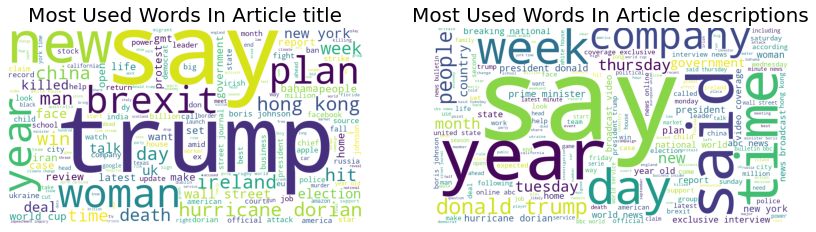

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[14,14])
wc1 = WordCloud(width=900,height=500,stopwords=STOPWORDS, background_color = 'white').generate(' '.join(df.cleaned_title))
wc2 = WordCloud(width=900,height=500,stopwords=STOPWORDS, background_color = 'white').generate(' '.join(df.cleaned_description))
ax1.imshow(wc1)
ax2.imshow(wc2)
ax1.axis('off')
ax2.axis('off')
ax1.set_title("Most Used Words In Article title",fontsize=20)
ax2.set_title("Most Used Words In Article descriptions",fontsize=20)
plt.show()

### Sentiment and Subjectivity Analysis

After having gone through some desciptive statistics of the article data set, more complex analysis can now be carried out. This is here done by looking into the text of the articles. Analyzing language is called Natural Language Processing (NLP) and contains a variety of topics - some of them are sentiment and subjectivity analysis which is covered in this section. 

The analysis have two main goals. Firstly, to provide sentiment and subjectivity scores in order to see, whether or not these can explain the engagement for articles and secondly to be a tool for getting better insight of the data. The tool used is [TextBlob](https://textblob.readthedocs.io/en/dev/), which is a library for processing textual data. It provides an API for diving into NLP tasks such as the ones used in this section.

The sentiment tool gives a result between -1 and 1, where -1 implies that the article is written in a very negative language, 0 implies neutral language and a score of 1 implies very positive language. The subjectivity tool provides a score between 0 and 1, where 0 is very objective and 1 very subjective language.

Even before carrying out the analysis one should assume that most articles are written in a neutral and objective language, however it is still interesting to see whether or not this assumption actually holds, and if there is any difference between the language of the different publishers.

In [14]:
from textblob import TextBlob
# function to calculate subjectivity
def getSubjectivity(review):
    return TextBlob(review).sentiment.subjectivity
    # function to calculate polarity
def getPolarity(review):
    return TextBlob(review).sentiment.polarity

# functions to label the articles
def analysis_sent(score):
    if score >= 0.5:
        return 'Positive'
    elif score <= -0.5:
        return 'Negative'
    else:
        return 'Neutral'

def analysis_subj(score):
    if score >= 0.5:
        return 'Subjective'
    else:
        return 'Objective'

In [15]:
#Creating columns for sentiment and subjectivity
df['subjectivityScore'] = df['cleaned_description'].apply(getSubjectivity)
df['polarityScore'] = df['cleaned_description'].apply(getPolarity)
df['polarity'] = df['cleaned_description'].apply(getPolarity).apply(analysis_sent)
df['subjectivity'] = df['cleaned_description'].apply(getSubjectivity).apply(analysis_subj)

In [16]:
#slicing dataframe
positive_art=df[df['polarity']=='Positive']
neutral_art=df[df['polarity']=='Neutral']
negative_art=df[df['polarity']=='Negative']
subj=df[df['subjectivity']=='Subjective']
obj=df[df['subjectivity']=='Objective']

#saving counts for ploting and printing
print("Total number of articles:", len(df))
count_neg=len(negative_art)
count_neu=len(neutral_art)
count_pos=len(positive_art)
count_subj=len(subj)
count_obj=len(obj)
print("Number of negative articles:", count_neg)
print("Number of neutral articles:", count_neu)
print("Number of positive articles:", count_pos)
print("Number of subjective articles:", count_subj)
print("Number of objective articles:", count_obj)

Total number of articles: 8720
Number of negative articles: 172
Number of neutral articles: 8082
Number of positive articles: 466
Number of subjective articles: 2437
Number of objective articles: 6283


The figure below shows the distribution of the sentiment scores. Clearly, the assumption of neutral language holds for the most part. However, more than 5% of the articles are classified as positive and the histogram on the right shows, that there are articles placed in every single bin - implying that there are both articles with very negative and positive language in the data set. 

In [17]:
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "pie"}, {"type": "histogram"}]]) #Making two plots

colors=['forestgreen','gold','indianred'] #Setting the color
labels = 'Positive', 'Neutral', 'Negative' #Setting the labels
values = [count_pos, count_neu, count_neg] #Stating the values for the pie plot

#Plotting the pie plot
fig.add_trace(go.Pie(labels=labels, values=values,name="",showlegend=False,
                     marker=dict(colors=colors,line=dict(color='#ffffff', width=6))),
     row=1, col=1)


#Plotting the histogram(negative)
fig.add_trace(go.Histogram(x=df.loc[df['polarity']=='Negative']['polarityScore'],
                           name="Negative",marker=dict(color="indianred"),xbins=dict(
        start=-1.0,
        end=1,
        size=0.1)),row=1, col=2)
#Plotting the histogram(positive)
fig.add_trace(go.Histogram(x=df.loc[df['polarity']=='Positive']['polarityScore'],
                           name="Positive",marker=dict(color="forestgreen"),xbins=dict(
        start=-1.0,
        end=1,
        size=0.1)),row=1, col=2)
#Plotting the histogram(neutral)
fig.add_trace(go.Histogram(x=df.loc[df['polarity']=='Neutral']['polarityScore'],
                           name="Neutral",marker=dict(color="gold"),xbins=dict(
        start=-1.0,
        end=1,
        size=0.1)),row=1, col=2)
fig.update_layout(hovermode="x unified",title_text='Sentiment distribution ',title_x=0.5) # title of plot)

config = {'displayModeBar': False}

fig.show(config=config)

The chart below shows the distribution of positive, negative and neutral articles in percentage of the total amount of articles published by each source. Interesting to see is that some publishers clearly writes in a more neutral language than others. The most neutral being Reuters with $<$2% positive and $<$1% negative articles. At the other extreme BBC News have more than 12% of their articles classified as using positive language and 2.7% as negative.

In [18]:
grouped_count=df.groupby(['source_name','polarity']).count().reset_index()
grouped_count=grouped_count[['source_name','polarity','description']] 
grouped_count['description'] = grouped_count['description'] / grouped_count.groupby('source_name')['description'].transform('sum')*100
grouped_count#Plotting

fig = px.bar(grouped_count, x="source_name", y="description", color="polarity", title="Sentiment distribution per publisher",
             labels={'description':'%','source_name':'Publisher','polarity':''}, color_discrete_map={
        'Positive': 'forestgreen',
        'Neutral': 'gold','Negative': 'indianred'})
for data in fig.data:
    data["width"] = 0.6 #Change this value for bar widths

fig.update_layout(hovermode="x unified",title_x=0.5, legend=dict(
        x=1.0,
        y=0.5,        
    ))

config = {'displayModeBar': False}
fig.show(config=config)

The next chart shows the distribution of subjectivity scores. Again, the assumption of objective language in articles hold for the most part, but actually $\sim$28% of the articles are classified as using subjective language. Important to note is that the threshold is set at 0.5, meaning that not all of the "subjective" articles are very subjective - this can also be seen in the histogram on the right 

In [21]:
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "pie"}, {"type": "histogram"}]]) #Making two plots

colors=['forestgreen','indianred'] #Setting the color
labels = 'Objective', 'Subjective' #Setting the labels
values = [count_obj, count_subj] #Stating the values for the pie plot

#Plotting the pie plot
fig.add_trace(go.Pie(labels=labels, values=values,name="",showlegend=False,
                     marker=dict(colors=colors,line=dict(color='#ffffff', width=6))),
     row=1, col=1)


#Plotting the histogram(Subjective)
fig.add_trace(go.Histogram(x=df.loc[df['subjectivity']=='Subjective']['subjectivityScore'],
                           name="Subjective",marker=dict(color="indianred"),xbins=dict(
        start=-1.0,
        end=1,
        size=0.1)),row=1, col=2)
#Plotting the histogram(Objective)
fig.add_trace(go.Histogram(x=df.loc[df['subjectivity']=='Objective']['subjectivityScore'],
                           name="Objective",marker=dict(color="forestgreen"),xbins=dict(
        start=-1.0,
        end=1,
        size=0.1)),row=1, col=2)
fig.update_layout(hovermode="x unified",title_text='Subjecivity distribution ',title_x=0.5) # title of plot)

config = {'displayModeBar': False}

fig.show(config=config)

To end this section, the average subjectivity score is shown for each publisher. Here it can be seen that all of the sources on average would be classified as using objective language as the average scores are below 0.5. Most of them are scored somwhere between 0.27 and 0.36 with only Business Insider being significantly more subjective on average and ABC News and Al Jazeera English being more objective on average.

In [24]:
source_plot = df.groupby('source_name').subjectivityScore.mean().sort_values(ascending=False)

fig = px.bar(x=source_plot.index, y = source_plot.values, height=500, width=800)
fig.update_xaxes(title_text='Publisher')
fig.update_yaxes(title_text='Avg. subjectivity score')
fig.update_xaxes(type='category')
fig.show()

### Topic modelling

This section aims to investigate how the text content of the articles best can be devided into topics. This is done for two main reasons. Firstly, as the goal of this study is to predict the engagement, it could seem likely that the topic of an article have an influence on the popularity of it. Secondly, it can serve as a descriptive tool to better understand, what was the main topics in the article during the time of the data set.

The study will use [Latent DirichletAllocation (LDA)](https://towardsdatascience.com/light-on-math-machine-learning-intuitive-guide-to-latent-dirichlet-allocation-437c81220158) to perform topic modeling on the data. It consists of two main parts; generating topics and assigning topics to the articles. Each of the articles will then be able to be described by a distribution of topics and each of the topics are described by a distribution of words. To do this analysis, an article's description will be used and more specifically, the cleaned version made in the Data Cleaning section. This is done as the model input only should contain meaningfull words in order to reduce noise - as for the sentiment analysis. 

At last, the input to the model is a collection of all the descriptions of articles - namely the 'corpus'. The topic model is first implemented to generate topics and label each article with the most appropriate topic. The model determines the optimal number of topics to represent the lyrics corpus based on a measure of [coherence](https://radimrehurek.com/gensim/models/coherencemodel.html). It should be noted that the LDA usually initializes with random variables and thus it could generate slightly different topics every time if a seed is not set.

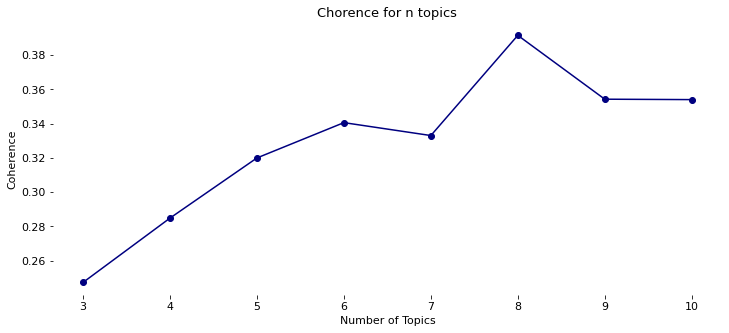

In [24]:
#Prepping model inputs
corpus = df['cleaned_description'].values.tolist()
tok_corp= [word_tokenize(sent) for sent in corpus]
lexi = corpora.Dictionary(tok_corp)
corpus = [lexi.doc2bow(d) for d in tok_corp]

plt.figure(figsize=(12, 5))

#Choose n parameter based on coherence measure
coherence_vals = []
for k in range(3,11):
    Lda = gensim.models.ldamodel.LdaModel
    ldamodel = Lda(corpus, num_topics=k,id2word = lexi, eval_every=None,passes=3,
               iterations=5,chunksize=100,random_state=123)

    cm = gensim.models.coherencemodel.CoherenceModel(\
         model=ldamodel, texts=tok_corp, dictionary=lexi, coherence='c_v')   

    coherence_vals.append((k,cm.get_coherence()))

n_topics = [x[0] for x in coherence_vals]
coherence = [x[1] for x in coherence_vals]

plt.plot(n_topics,coherence,color='navy')
plt.scatter(n_topics,coherence,color='navy')
plt.xlabel('Number of Topics',fontsize=11,color='black')
plt.ylabel('Coherence', fontsize=11,color='black')
plt.xticks(n_topics,fontsize=11,color='black')
plt.yticks(fontsize=11,color='black')
plt.title('Chorence for n topics',fontsize=13,color='black')
plt.box(False)

#plt.show()

From the coherence measure the optimal number of topics is $n=8$. Again, with the reservation that this is only run for 3 to 10 topics and that it can change due to the randomness of the model.

In [26]:
#Running the LDA model with the optimal number of topics found above
n_sub_topics= 3+coherence.index(max(coherence))
lda = LdaModel(corpus=corpus, id2word=lexi, iterations=5,chunksize=100, passes=3,num_topics=n_sub_topics, 
          update_every=1, alpha='auto', random_state=123,eval_every=None)

In [27]:
#Finding the topics 
topic_data =  pyLDAvis.gensim_models.prepare(lda, corpus, lexi, mds = 'pcoa')
all_topics = {}
num_terms = 10 # Adjust number of words to represent each topic
lambd = 0.8# Adjust this accordingly based on tuning above
for i in range(1,n_sub_topics+1): #Adjust this to reflect number of topics chosen for final LDA model
    topic = topic_data.topic_info[topic_data.topic_info.Category == 'Topic'+str(i)].copy()
    topic['relevance'] = topic['loglift']*(1-lambd)+topic['logprob']*lambd
    all_topics['Topic '+str(i)] = topic.sort_values(by='relevance', ascending=False).Term[:num_terms].values
    topic_df = pd.DataFrame(all_topics).T
#Display keywords that represents each topic
topic_df

0         1          2            3        4             5  \
Topic 1        say      week  wednesday         said    woman      minister   
Topic 2       said  thursday      china      company    stock       ukraine   
Topic 3       year       old       just       target     case  investigates   
Topic 4  president     trump      state       donald  officer          hour   
Topic 5        new      time    million         york     city       inquiry   
Topic 6     police    people        day         like      joe         biden   
Topic 7      story  business      house  impeachment      way      investor   
Topic 8       news     world   national        video   online     interview   

                6         7          8         9  
Topic 1    report     prime     latest  european  
Topic 2     month     trade     market   country  
Topic 3   october    killer         th    health  
Topic 4      home      read       dead     photo  
Topic 5       son     start    quarter    season  
Topic 6   morning      life     killed      open  
Topic 7      deal      told      phone      want  
Topic 8  coverage  breaking  exclusive       abc

The 8 topics and their 10 most key words are shown above in the table. Safe to say that many of the topics somewhat related to politics. In topic 1 there are words such as *Prime* and *Minister*, topic 4 is related to *President Donald Trump* and Topic 6 contains *Joe Bidens* name. Then there is topic 3 which seems to be about crime cases containing words as *Case*, *Invastigates* and *Killer*, and a *Breaking News* topic in topic 8.

The performance of the LDA can be examined further by used the interactive visualizer as shown below. Here the topics are shown in a 2D space on he left and the chart on the right shows the words that describes the given topic. This bar chart on the right is linked to the tunable $\lambda$-parameter which is based on the TF-IDF. A high $\lambda$-value gives more importance to the term frequency and vice versa.

In [28]:
pyLDAvis.display(topic_data)

The articles are now assigned to the different topics. With this it is possible to look at the relevance of topics in the context of engangement prediction a little later.

In [118]:
train_vecs = []
for i in range(len(df)):
    top_topics = lda.get_document_topics(corpus[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(3+coherence.index(max(coherence)))]
    train_vecs.append(topic_vec)

In [119]:
topics = pd.DataFrame(train_vecs,columns = ['topic1','topic2','topic3','topic4','topic5','topic6','topic7','topic8'])
df = pd.concat([df, topics], axis=1)

### HSV

Before exploring the more advanced models it could also be interesting to investigate whether it is possible to predict the total engagement based on the mean value of HSV colors for each image. 

Explanation on the HSV colors can be found in this [link](https://realpython.com/python-opencv-color-spaces/).     
* H = Hue (color)
* S = Saturation (the shades of hue) 
* V = Value (brightness of the color)

<div>
    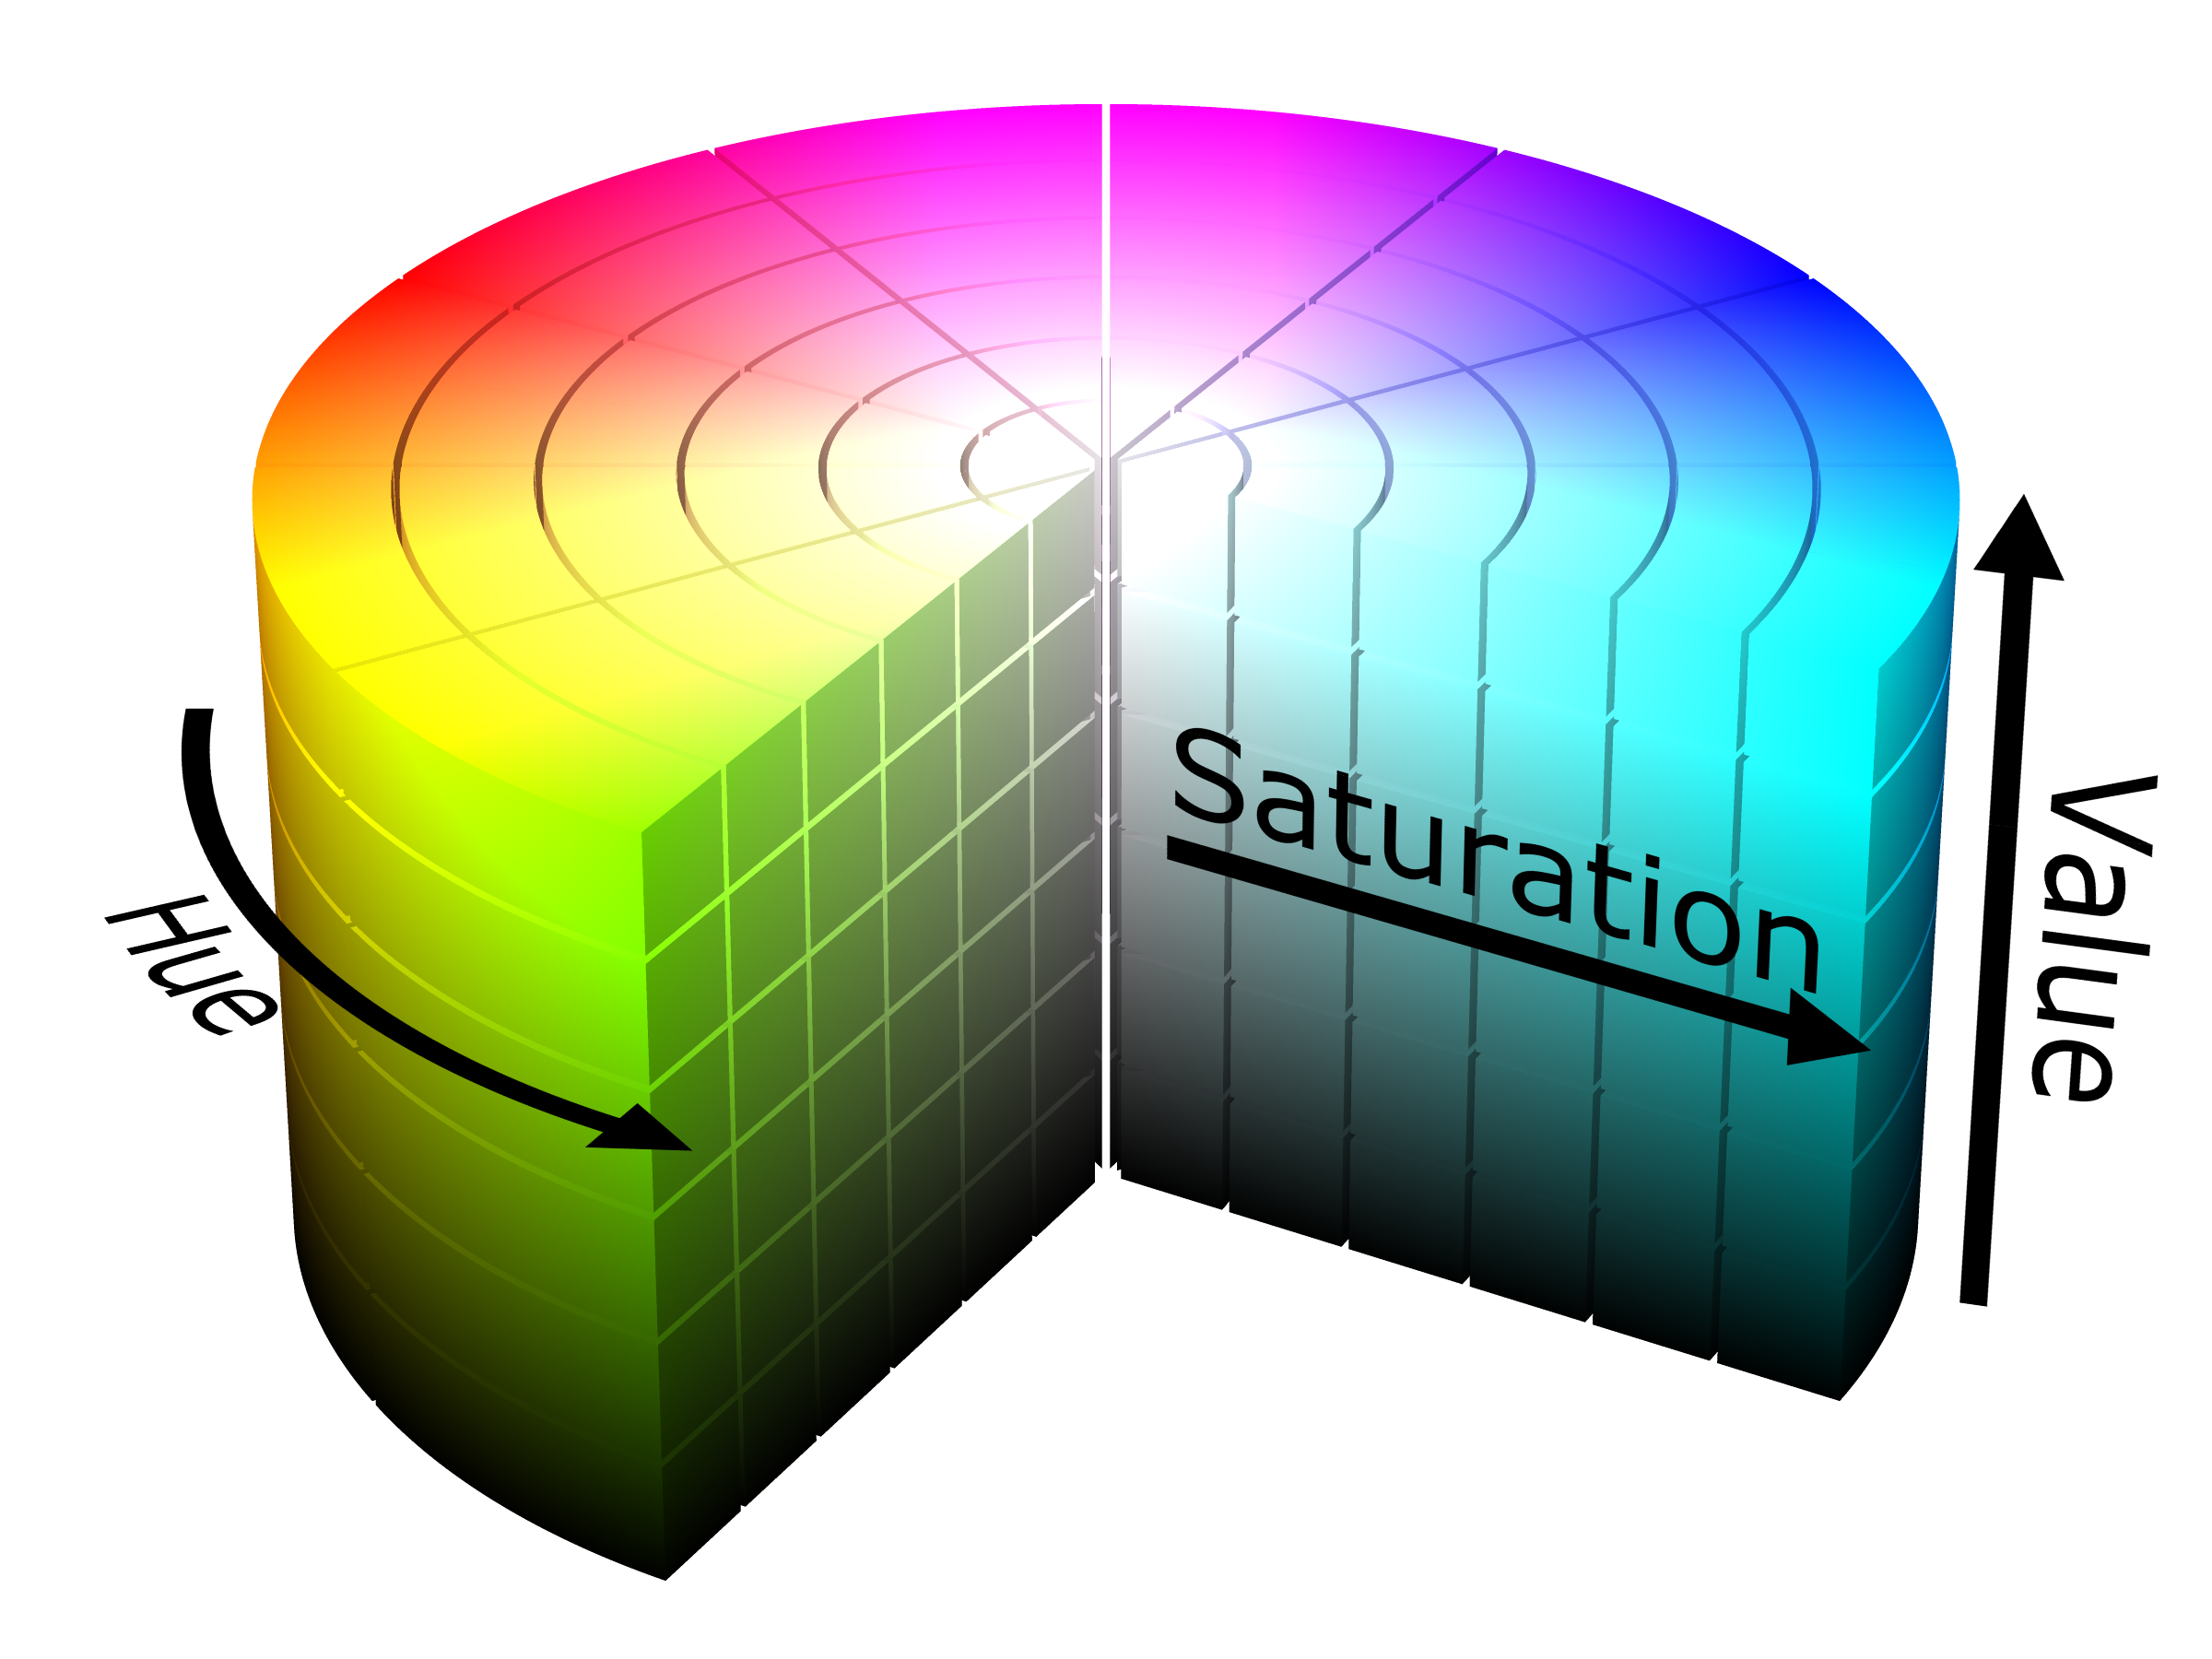
</div>



The following function process an image and finds the HSV colors. Finally it takes the mean value of the HSV colors.

In [120]:
#function to process one image
def process_image(url):
    res = requests.get(url)
    im = imageio.imread((res.content))

    #get dims
    width = im.shape[1]
    height = im.shape[0]
    dimensions = im.ndim
    
    #getting the HSV colors
    mean_hsv = cv2.mean(cv2.cvtColor(im, cv2.COLOR_BGR2HSV))    
    hue_mean = mean_hsv[0]
    sat_mean = mean_hsv[1]
    bright_mean = mean_hsv[2]
    
    #return mean values
    return width,height,dimensions, hue_mean,sat_mean,bright_mean

The function is run for every image in the dataset. 

In [186]:
'''
df[["img_width", "img_height", 'img_dim', 'img_hue', 'img_sat', 'img_val']] = np.nan

In [187]:
#WARNING: This code has a very long runtime. The output data has been saved in a new csv. So download this instead.
'''
for i in range(len(df)):
    url = df.iloc[i]["url_to_image"]
    if pd.isna(url) == False:
        try:
            width,height,dimensions,hue_mean,sat_mean,bright_mean = process_image(url)
            df["img_width"][i],  df["img_height"][i], df["img_dim"][i], df["img_hue"][i], df["img_sat"][i], df["img_val"][i] = width,height,dimensions,hue_mean,sat_mean,bright_mean
        except:
            pass

In [188]:
#df.to_csv('df_hsv.csv')

In [121]:
hsv = pd.read_csv("df_hsv.csv", index_col=0)
hsv=hsv[['img_hue','img_sat','img_val']]
df = pd.concat([df,hsv], axis=1)

Let's check if the found HSV values makes sense, by printing the images with the highest and lowest values.

In [122]:
print("Row with highest Hue:", df['img_hue'].idxmax())
print("Row with highest Saturation:", df['img_sat'].idxmax())
print("Row with highest Brightness:", df['img_val'].idxmax())
print("--------------------------------------------")
print("Row with lowest Hue:", df['img_hue'].idxmin())
print("Row with lowest Saturation:", df['img_sat'].idxmin())
print("Row with lowest Brightness:", df['img_val'].idxmin())

Row with highest Hue: 1033
Row with highest Saturation: 1650
Row with highest Brightness: 527
--------------------------------------------
Row with lowest Hue: 14
Row with lowest Saturation: 14
Row with lowest Brightness: 3593


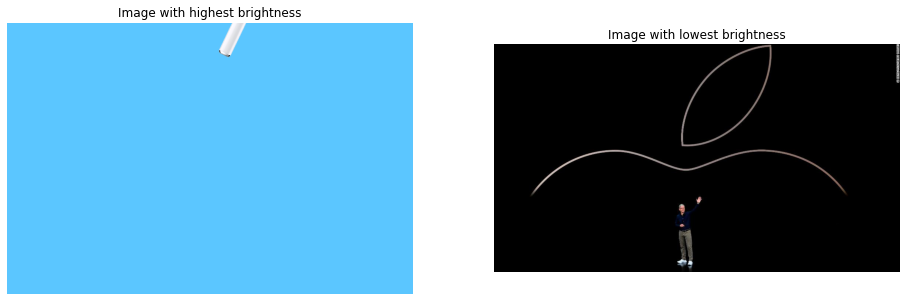

In [123]:
f, ax = plt.subplots(1, 2, figsize=(16,6))
ax[0].imshow(imageio.imread(df.iloc[df['img_val'].idxmax()].url_to_image))
ax[1].imshow(imageio.imread(df.iloc[df['img_val'].idxmin()].url_to_image))
ax[0].axis('off')
ax[1].axis('off')

ax[0].set_title('Image with highest brightness')
ax[1].set_title('Image with lowest brightness')
plt.show()

Makes sense. 

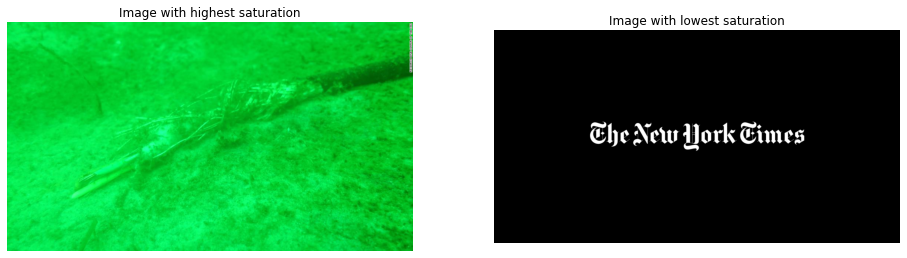

In [124]:
f, ax = plt.subplots(1, 2, figsize=(16,6))
ax[0].imshow(imageio.imread(df.iloc[df['img_sat'].idxmax()].url_to_image))
ax[1].imshow(imageio.imread(df.iloc[df['img_sat'].idxmin()].url_to_image))
ax[0].axis('off')
ax[1].axis('off')

ax[0].set_title('Image with highest saturation')
ax[1].set_title('Image with lowest saturation')
plt.show()

Makes sense. 

### Correlation with engagement



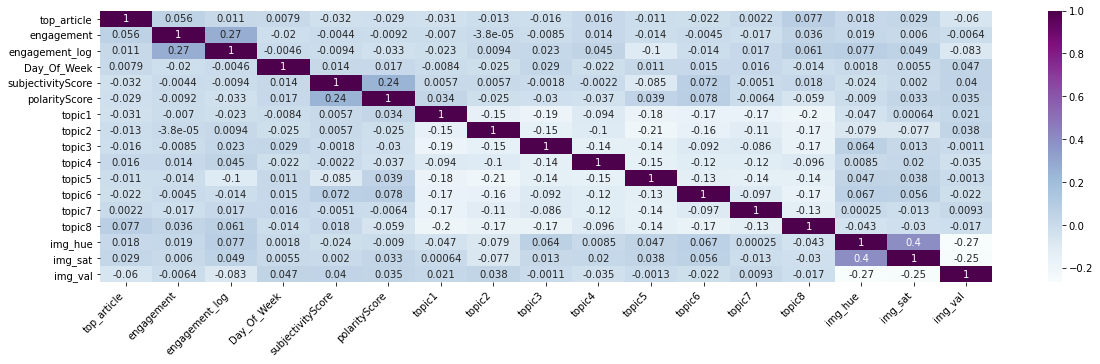

/Users/juliusrasmussen/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/juliusrasmussen/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/juliusrasmussen/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/juliusrasmussen/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [127]:
g = sns.heatmap(df.corr(), cmap="BuPu", annot=True)
g.set_xticklabels(g.get_xticklabels(), rotation = 45, horizontalalignment = 'right')
plt.show()

### Split data

To evaluate the generalization error of our models we need to split the data. We split it into a train (72%), val (8%) and test (20%) set.

In [1]:
from sklearn.model_selection import train_test_split
y = np.array(df[['engagement','engagement_log','top_article']])
X = np.array(df[['source_name','title','cleaned_title','description','cleaned_description', 
                 'url_to_image','filepath','polarityScore','subjectivityScore']])
X_par, X_test, y_par, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_par, y_par, test_size=0.10, random_state=42)

NameError: name 'np' is not defined

In [31]:
X_train=pd.DataFrame(X_train, columns=['source_name','title','cleaned_title','description','cleaned_description','url_to_image','filepath',
                                       'polarityScore','subjectivityScore'])
X_val=pd.DataFrame(X_val, columns=['source_name','title','cleaned_title','description','cleaned_description','url_to_image','filepath',
                                   'polarityScore','subjectivityScore'])
X_test=pd.DataFrame(X_test, columns=['source_name','title','cleaned_title','description','cleaned_description','url_to_image','filepath',
                                     'polarityScore','subjectivityScore'])

y_train = pd.DataFrame(y_train, columns=['engagement','engagement_log', 'top_article'])
y_val = pd.DataFrame(y_val, columns=['engagement','engagement_log', 'top_article'])
y_test = pd.DataFrame(y_test, columns=['engagement','engagement_log', 'top_article'])

In [32]:
import pickle

pickle.dump(X_train, open("X_train.p", "wb"))
pickle.dump(y_train, open("y_train.p", "wb"))
pickle.dump(X_val, open("X_val.p", "wb"))
pickle.dump(y_val, open("y_val.p", "wb"))
pickle.dump(X_test, open("X_test.p", "wb"))
pickle.dump(y_test, open("y_test.p", "wb"))

In [33]:
#df.to_csv('df_cleaned.csv')

## Modelling

article review --> https://towardsdatascience.com/analyzing-and-predicting-consumer-engagement-8b3229f0cbad. Forklar hvad artiklen har gjort, og hvad vi vil gøre. 

In [6]:
import pickle
X_train = pickle.load(open("X_train.p", "rb"))
X_val =  pickle.load(open("X_val.p", "rb"))
X_test =  pickle.load(open("X_test.p", "rb"))
y_train = pickle.load(open("y_train.p", "rb"))
y_val = pickle.load(open("y_val.p", "rb"))
y_test = pickle.load(open("y_test.p", "rb"))

### Baseline (mean)

In [7]:
y_pred = np.mean(y_train['engagement_log'])
y_pred = np.array([y_pred]*len(y_test))

In [11]:
print("RMSE: ",round(np.sqrt(mean_squared_error(y_pred,y_test['engagement_log'])),2))

RMSE:  2.65


### Light GBM regressor

In [12]:
X_train = pd.concat([X_train,X_val], axis = 0)
y_train = pd.concat([y_train,y_val], axis = 0)

In [13]:
tfidf_vec = TfidfVectorizer(ngram_range=(1,2),
                            dtype=np.float32, 
                            sublinear_tf=True, 
                            use_idf=True, 
                            smooth_idf=True)
train_tfidf = tfidf_vec.fit_transform(X_train['cleaned_description'])
test_tfidf = tfidf_vec.transform(X_test['cleaned_description'])

In [14]:
model1 = LGBMRegressor(verbose=-1,
                       learning_rate=0.01,
                       max_depth=20,
                       num_leaves=50,
                       n_estimators=150)

In [15]:
model1.fit(train_tfidf,y_train['engagement_log'])
pred1 = model1.predict(test_tfidf)
print("RMSE: ",round(np.sqrt(mean_squared_error(pred1,y_test['engagement_log'])),2))

RMSE:  2.57


## CNN

## BERT model

From above it is evident that the often used ensemble algorithms does a poor job of predicting the engagement count of news articles posted on facebook. 

**Introduction to BERT model**

Continuing in the text domain, one hypothesis may be that the semantic meaning and the order of the words is better at explaining the facebook engagement of an article. To model this we have used the NLP model called Bi-Directional Encoder Representations from Transformers (BERT) model. The model relies heavily on the "Transformer" architecture, which was introduced in the now infamous article, "Attention Is All You Need" [Vaswani et al. 2017]. The conceptual idea of the application of the BERT model is that you download an already pre-trained model, add a suitable dense layer on top and fine-tune the entire model on your training data. The BERT model has been pre-trained on 16GB of text data in an unsupervised manner that has ensured that the transformer layers (110 million parameters) of the model has "learnt" the english language. The BERT model is available to download via the huggingface API (www.huggingface.co).


The tranformer architecture has more or less substituted LSTM and other recurrent neural network based models for NLP tasks. The main advantage of the transformer is that it allows faster training through parallelization, avoidance of the vanishing gradient problem, and enables transfer learning to a higher degree than before.

An input sentence (sequence of tokens) is fed to the model, and along with the token is a positional encoding. The positional encoding allows the model to interpret the correct meaning of a sentence accounting for the semantics of the words and also the context of the words - just as humans do - contrary to the tf-idf principle where the uniqueness and popularity of the words are the only sources of information.


**Implementation of BERT model**

As the fine-tuning of the BERT model is cumbersome (as all parameters in transformer models are fine-tuned), the training has been done using one of Colabs GPU's for speed enhancement. This means that the below cells are mostly copied from Colab, and thus not run in this local notebook. However, as the training is a central part it is included below. We install the required packages, here among the transformers (the huggingface api) and wandb (similar to TensorBoard). Next we load the tokenizer and the model of interest from the huggingface api, tokenize the data and create a custom dataset class (required by PyTorch framework). For the training of the model we take advantage of the Trainer argument that comes with the huggingface library, hence, we define the training arguments, evaluation metrics and finally the trainer object. The model is now easily trained.

To ensure that we do not overfit (which the model is very prone to), we use a validation set and use the EarlyStoppingCallback ensures that the training stops if we haven't improved the performance of the test in a while.

A tuning of the hyperparameters have happened and the best performance have been obtained using the default (huggingface) learning rate of 5e-5, a batch_size of 16 and evaluation steps of 100.


**ADD TABLE!**








In [ ]:
!pip3 install transformers==4.8.2
!pip install wandb

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import torch
from transformers import TrainingArguments, Trainer
from transformers import BertTokenizer, BertForSequenceClassification,RobertaForSequenceClassification, RobertaTokenizer
from transformers import EarlyStoppingCallback

The data is loaded from the pickles. In the input, X, we use both the title and description, as both may contain information valuable for the model.

In [ ]:
X_train = pickle.load(open("drive/MyDrive/ABA project/X_train.p", "rb"))
X_val =  pickle.load(open("drive/MyDrive/ABA project/X_val.p", "rb"))
X_test =  pickle.load(open("drive/MyDrive/ABA project/X_test.p", "rb"))
y_train = pickle.load(open("drive/MyDrive/ABA project/y_train.p", "rb"))
y_val = pickle.load(open("drive/MyDrive/ABA project/y_val.p", "rb"))
y_test = pickle.load(open("drive/MyDrive/ABA project/y_test.p", "rb"))

X_train = list(X_train['title'] + X_train['description'])
X_val = list(X_val['title'] + X_val['description'])
X_test = list(X_test['title'] + X_test['description'])
y_train = list(np.log1p(y_train['engagement']))
y_val = list(np.log1p(y_val['engagement']))
y_test = list(np.log1p(y_test['engagement']))

In [ ]:
#download the pre-trained model and tokenizer from the huggingface api. 
#Note that we download the model from BertForSequenceClassification, which may seem odd, but as we indicate
#that we only have one label the model in fact contains a regression layer on top.
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=1)

In [ ]:
#The data is tokenized. We use a max_length of 128 tokens, which ensures that all words for all sentences are
#fed to the model.

X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=128)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=128)

In [ ]:
# Create torch dataset.
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.squeeze(torch.tensor(self.labels[idx]))
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

#create dataset objects
train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)

In [ ]:
# Define Trainer parameters

def compute_metrics_reg(p):
    pred, labels = p

    MSE = mean_squared_error(y_true = labels, y_pred = pred)
    r2 = r2_score(y_true = labels, y_pred = pred)
    MAE = mean_absolute_error(y_true = labels, y_pred = pred)
    RMSE = mean_squared_error(y_true = labels, y_pred = pred, squared = False)

    return {"rmse": RMSE, "mse": MSE, "r2": r2, "mae": MAE}

# Define Trainer
args = TrainingArguments(
    output_dir="Bert16",
    evaluation_strategy="steps",
    eval_steps=100,
    logging_steps = 100,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=30,
    learning_rate = 5e-5,
    seed=0,
    load_best_model_at_end=True,
    report_to="wandb"
)
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics_reg,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

In [ ]:
#train/finetune pre-trained model
trainer.train()

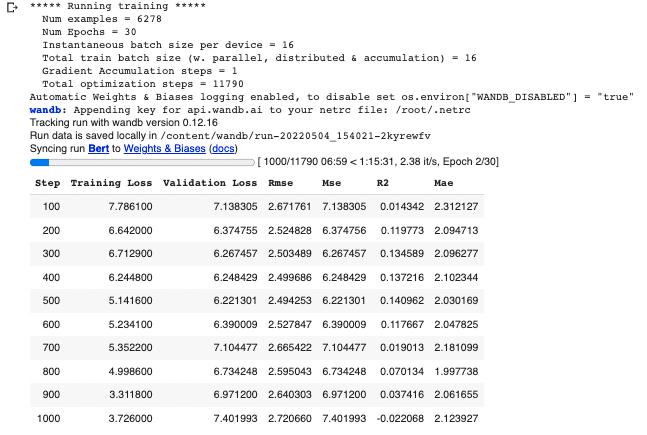


Above we see how the training loss and validation loss decreases. At a point (around 400-500 steps) the validition loss starts to increase again, which is indication of overfitting. As we used the option to load best model at end, we save the model state of step 500. We can now to inference on the model and run it on the unseen data (test dataset).

In [ ]:
#Predict
#tokenize test data
X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=128)

#create torch dataset
test_dataset = Dataset(X_test_tokenized)

# Define test trainer
test_trainer = Trainer(model)

# Make prediction
y_pred, _, _ = test_trainer.predict(test_dataset)

In [ ]:
def evaluate(pred, label):
    labels = label
    MSE = mean_squared_error(y_true = labels, y_pred = pred)
    r2 = r2_score(y_true = labels, y_pred = pred)
    MAE = mean_absolute_error(y_true = labels, y_pred = pred)
    RMSE = mean_squared_error(y_true = labels, y_pred = pred, squared = False)

    return {"rmse": RMSE, "mse": MSE, "r2": r2, "mae": MAE}

In [2]:
evaluate(y_pred, y_test)


{'mae': 1.9328157435774105,
 'mse': 5.817625617246185,
 'r2': 0.17319787498805883,
 'rmse': 2.411975459503306}

In [ ]:
plt.scatter(y_test, y_pred)
plt.xlabel("true")
plt.ylabel("predicted")

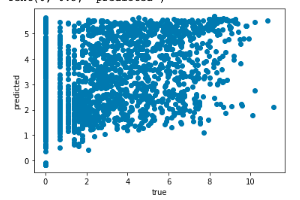

**ADD PLOT**

The BERT model is to some extent able to predict the engagement of a facebook article. The RMSE is 2.37 and the R2 0.2. Thus compared to the LightGBM model (and baseline) the BERT model is better able to predict the facebook engagement. Intuitively, this makes sense as the context of the words and the semantic meaning should yield extra information compared to the tf-idf.


The model was uploaded to the huggingface library and can be found here https://huggingface.co/jenspt/bert_regression_basic_16_batch_size

## BERT model with simple extension

In the descriptive analysis we saw that the engagement was correlated with the publisher. In the figure (reference - hvordan???) it was clear that New York Times??? was more likely to achieve articles with high engagement. Why don't we add this information to the model.

As we will be extending the previous BERT model with this information, we need to modify the structure of the model to accomodate an extra input vector corresponding to the publisher of the article. In practice the publisher column is a categorial and thus we simply do one-hot-encoding.



In [ ]:
#import dependencies
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss, MSELoss

#Load data from pickles
X_train_source = np.array(pd.get_dummies(X_train['source_name']))
X_val_source = np.array(pd.get_dummies(X_val['source_name']))
X_test_source = np.array(pd.get_dummies(X_test['source_name']))

X_train_text = list(X_train['title'] + X_train['description'])
X_val_text = list(X_val['title'] + X_val['description'])
X_test_text = list(X_test['title'] + X_test['description'])
y_train = list(np.log1p(y_train['engagement']))
y_val = list(np.log1p(y_val['engagement']))
y_test = list(np.log1p(y_test['engagement']))

As we are creating a custom model, we this time need to create a class that extends the torch.nn.Module class. 

In this class we define the structure of our model, the forward pass and the loss function. 


In the inialization of the model, the pre-trained BERT model is downloaded without the dense layer for regression. A "custom" dense layer is specified where the input dimension is equal to that of the BERT output + the publisher vector. It is in this way that the publisher information is included in the model.

A forward pass consists of the tokenized text input going through the BERT model. Afterwards the BERT output is concatenated with the publisher vector which is then sent through the regression dense layer. To avoid overfitting, a dropout is used during training for the dense layer (and automatically also for the bert model).

The loss is simply the mean squared error - similar to what we used in the previous model.

In [ ]:
#Custom model
class BertCNN(nn.Module):
    def __init__(self, drop_rate=0.2):
        super().__init__()

        D_in_Bert = 768
        D_in_source = 12 #different source_names
        D_out = 1

        #bert
        self.bert = BertModel.from_pretrained("bert-base-uncased")
      
        #dense layer 
        self.dropout = nn.Dropout(drop_rate)
        self.regressor = nn.Linear(D_in_Bert+D_in_source, D_out) #from bert and source/publisher

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
        source=None,
        image=None,
    ):

        bert_outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        #from bert
        pooled_output = bert_outputs[1]
        pooled_output = self.dropout(pooled_output)


        #combined
        combined_output = torch.cat([pooled_output, source], dim = 1)#, image

        logits = self.regressor(combined_output)#(pooled_output)

        loss = None
        if labels is not None:
            #  We are doing regression
            loss_fct = MSELoss()
            loss = loss_fct(logits.view(-1), labels.view(-1))
        return (loss, logits)


In [ ]:
#init model
model = BertSource(drop_rate=0.2)

#We use the same tokenizer as before.

In [ ]:
#The dataset class now needs to handle the publisher data
# Create torch dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, source, labels=None):
        self.encodings = encodings
        self.labels = labels
        self.source = source

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["source"] = torch.squeeze(torch.tensor(self.source[idx,:])) # add source_name to dataset
        if self.labels:
            item["labels"] = torch.squeeze(torch.tensor(self.labels[idx]))
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

train_dataset = Dataset(X_train_tokenized, X_train_source, y_train)
val_dataset = Dataset(X_val_tokenized, X_val_source, y_val)

In [ ]:
#We define a new Trainer object using the new model
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics_reg,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)],
)

In [ ]:
#and we train again...
trainer.train()

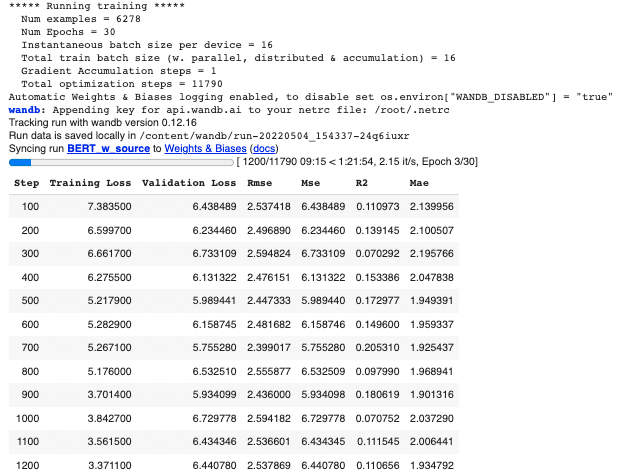

This time the best model is at step 700.

In [ ]:
#time to check test performance

#create torch dataset with test data
test_dataset = Dataset(X_test_tokenized, X_test_source, y_test)

# Define test trainer
test_trainer = Trainer(model)

# Make prediction
y_pred, _, _ = test_trainer.predict(test_dataset)

In [ ]:
evaluate(y_pred, y_test)

{'mae': 1.8969350324486995,
 'mse': 5.62968507184602,
 'r2': 0.19990802317155676,
 'rmse': 2.3726957394166703}

We can see that the performance of the model has increased! We now have a RMSE of 2.37 and a R2 of 0.20. Still far from perfect but it shows that the model is able to learn the biases of the publishers.


## A SuperModel!

So far we have tried to model the engagement based on the text and the images seperately. What if we combine the two models and thus try to make a super model that uses information both the images and the text - exactly what us humans do when scrolling through facebook!

